# 取り組み

来週のPR用に、シークエンスエラーの補正前後における変異率をプロットする

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if os.getcwd() != "/mnt/d/Research/DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/d/Research/DAJIN2


# 実験

In [2]:
from __future__ import annotations

import sys, os
from pathlib import Path

sys.path.append("/mnt/d/Research/DAJIN2")
os.chdir("/mnt/d/Research/DAJIN2")

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)

##### # * Subset of Point mutation
##### # 50 or 10 or 01%
percent = "01"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    f"test-tyr-albino-{percent}%",
    "mm10",
    True,
    14,
)

# ##### # * Point mutation
# SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
#     "examples/pm-tyr/barcode31.fq.gz",
#     "examples/pm-tyr/barcode32.fq.gz",
#     "examples/pm-tyr/design_tyr.fa",
#     "test-pm-tyr",
#     "mm10",
#     True,
#     14,
# )


# ##### # * 2-cut deletion
# SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
#     "tests/data/knockout/test_barcode25.fq.gz",
#     "tests/data/knockout/test_barcode30.fq.gz",
#     "tests/data/knockout/design_stx2.fa",
#     "test-knockout",
#     "mm10",
#     True,
#     14,
# )

# #### #* 2-cut deletion
# SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
#     "examples/del-stx2/barcode25.fq.gz",
#     "examples/del-stx2/barcode30.fq.gz",
#     "examples/del-stx2/design_stx2.fa",
#     "test-stx2-deletion",
#     "mm10",
#     True,
#     14,
# )

# #### * flox insertion
# SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
#     "examples/flox-cables2/AyabeTask1/barcode31.fq.gz",
#     "examples/flox-cables2/AyabeTask1/barcode42.fq.gz",
#     "examples/flox-cables2/AyabeTask1/design_cables2.fa",
#     "test-ayabe-task1",
#     "mm10",
#     True,
#     14,
# )

print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

################################################################################
# Export fasta files as single-FASTA format
################################################################################
# TODO: use yeild, not export
for identifier, sequence in FASTA_ALLELES.items():
    contents = "\n".join([">" + identifier, sequence]) + "\n"
    output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
    output_fasta.write_text(contents)
###############################################################################
# Mapping with mappy
###############################################################################
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
########################################################################
# MIDSV conversion
########################################################################
for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)


processing test-tyr-albino-01%...


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

allele = "control"
sequence = FASTA_ALLELES[allele]


In [4]:
import midsv
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
coverage_sample = len(midsv_sample)
coverage_control = len(midsv_control)
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

In [18]:
from collections import Counter
def calc_mutation_percentage(cssplits_sample):
    coverage = len(cssplits_sample)
    transposed = [list(t) for t in zip(*cssplits_sample)]
    insersion = []
    deletion = []
    substitution = []
    for t in transposed:
        cnt = Counter(t)
        num_ins = 0
        num_del = 0
        num_sub = 0
        for key, val in cnt.items():
            if key.startswith("="):
                continue
            if key.startswith("+"):
                num_ins += val / coverage * 100
            if key.startswith("-"):
                num_del += val / coverage * 100
            if key.startswith("*"):
                num_sub += val / coverage * 100
        insersion.append(num_ins)
        deletion.append(num_del)
        substitution.append(num_sub)
    return insersion, deletion, substitution

In [31]:
from copy import deepcopy
before_cssplits_sample = deepcopy(cssplits_sample)
before_ins, before_del, before_sub = calc_mutation_percentage(before_cssplits_sample)

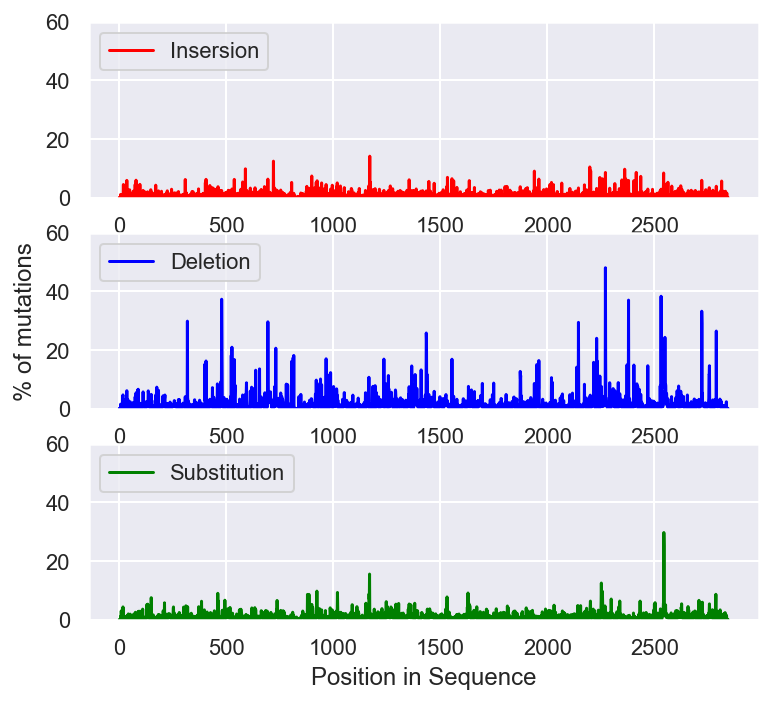

In [77]:
fig = plt.figure(figsize = (6,5.5))
#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す
ax1.plot(before_ins, color="red", label="Insersion")
ax2.plot(before_del, color="blue", label="Deletion")
ax3.plot(before_sub, color="green", label="Substitution")

ax2.set_ylabel("% of mutations")
ax3.set_xlabel("Position in Sequence")

ax1.set_ylim(0, 60)
ax2.set_ylim(0, 60)
ax3.set_ylim(0, 60)

# 凡例表示
ax1.legend(loc = 'upper left') 
ax2.legend(loc = 'upper left') 
ax3.legend(loc = 'upper left') 

plt.show()

In [78]:
fig.savefig("tmp_before.jpg", dpi = 600)

In [33]:
count = defaultdict(int)
for cs in cssplits_sample:
    count[cs[828]] += 1
print(count)

defaultdict(<class 'int'>, {'=G': 9116, 'N': 3, '*GT': 80, '=c': 1, '-G': 1, '+A|=G': 1})


In [34]:
###############################################################################
# Correct CSSPLITS
###############################################################################
preprocess.correct_revititive_deletions.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

import midsv
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
coverage_sample = len(midsv_sample)
coverage_control = len(midsv_control)
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

from copy import deepcopy
after_cssplits_sample = deepcopy(cssplits_sample)
after_ins, after_del, after_sub = calc_mutation_percentage(after_cssplits_sample)

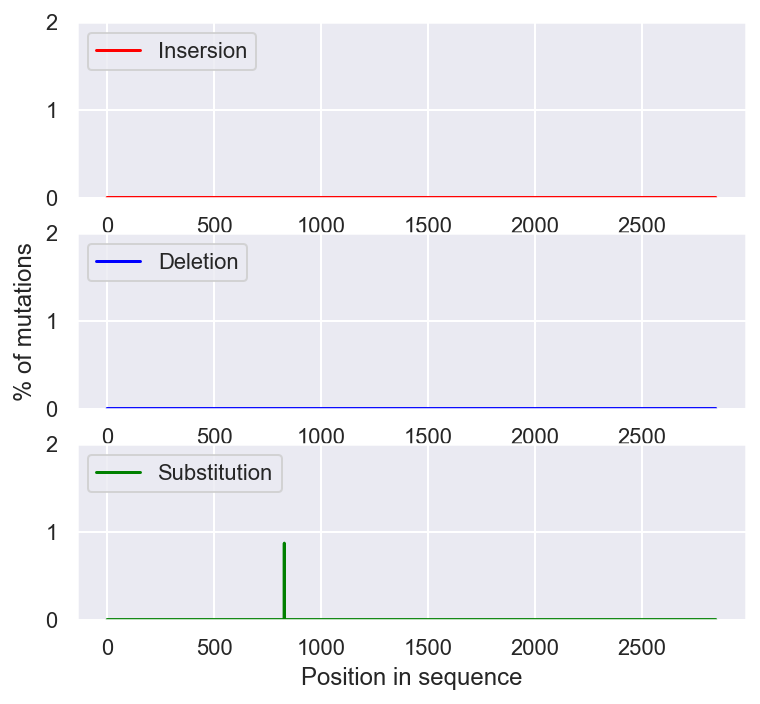

In [75]:
fig = plt.figure(figsize = (6,5.5))
#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す
ax1.plot(after_ins, color="red", label="Insersion")
ax2.plot(after_del, color="blue", label="Deletion")
ax3.plot(after_sub, color="green", label="Substitution")

ax2.set_ylabel("% of mutations")
ax3.set_xlabel("Position in sequence")

ax1.set_ylim(0, 2)
ax2.set_ylim(0, 2)
ax3.set_ylim(0, 2)

# 凡例表示
ax1.legend(loc = 'upper left') 
ax2.legend(loc = 'upper left') 
ax3.legend(loc = 'upper left') 

plt.show()

In [76]:
fig.savefig("tmp_after.jpg", dpi = 600)

# 結果


目的のFigをつくることができた

# 次回の課題

改めて`2023-02-15`に戻ってコサイン類似度以外の手法を比較検討する。


+ [x] ~~点変異、欠失、ノックインのデザインで動くかを確認する~~
+ [x] ~~Clusteringのときの警告メッセージは無害なので消去する~~
+ [ ] right_loxpがいまいちな理由を考察する
    +  ~~[x] Ayabe-task1のpreprocessにおいて、329と1280の補正がされていない理由を検討する~~
+ [x] ~~distanceの閾値を下げた状態で、1%点変異が検出できるか~~
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか